# 3D (x-y-t) field inference: array optimization


In [1]:
import os
from tqdm import tqdm
#import pickle

import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import corner
import arviz as az

import nwastats as st
colors = st.colors
day = 86400

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

In [ ]:
# actually run production inferences
#prod=True
prod=False

local_cluster = True
#if prod:
#    local_cluster = False

if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=20, processes=20, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="00:30:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=5)

client = Client(cluster)
client

## Prepare distribution of computations

Computations to be distributed:

- Fixed station inference
- Lagrangian simulation and inference


In [3]:
# flow case
U = "0.1"
#case = "3D_matern32_iso_matern12_pp_r0.0_u"+U
case = "3D_matern52_iso_matern12_pp_r0.0_u"+U
run_dir = os.path.join(data_dir, case)

# inference input parameters
uv = True # True if u and v are observed
parameter_eta_formulation = False # eta vs nu formulation
noise = 0.01 # observation noise added to u/v
no_time = False # activates time inference
no_space = False
traj_decorrelation = False  # artificially decorrelate different moorings/drifters
enable_nu = False

# number of points used for inference#
#Nxy, Nt = 1, 50
Nxy, Nt = 2, 50
#Nxy, Nt = 5, 50
#Nxy, Nt = 10, 50

# run multiple Nxy at once
Nxy = [1, 2, 4, 8, 16]

# number of ensembles
#Ne = 10 # dev
Ne = 100 # prod

dx = None
#dx = 100. # Nxy>1, separation between platforms
#dx = [20, 50, 100, 150, 200]
dx = ("spiral", 50, 300)

burn = 500 # number of samples to drop (burning)

In [4]:
# prepare inference & common utils
dsf, covfunc, covparams, labels = st.prepare_inference(
    run_dir,
    uv, no_time, no_space,
    parameter_eta_formulation, 
    traj_decorrelation,
    enable_nu,
)
flow_attrs = dict(**dsf.attrs)
truth = {k: v for k, v in zip(labels, [noise]+covparams)}

U 0.1
amplitude0 7.745966692414835
amplitude1 0.0
cov_t matern12
cov_x matern52_iso
cov_y matern52_iso
eta 7.745966692414835
kind pp
lambda_t 5
lambda_x 100
lambda_y 100
nu_space 2.5
nu_time 0.5
noise 0.0
pp_ratio 0.0
dx 2.0
dy 2.0


---

## run/load inferences

### moorings

In [5]:
def load_mooring(Nxy, dx):    
    print(Nxy, dx)
    
    # build output file name
    nc = os.path.join(run_dir, f"moorings_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        if st.is_number(dx):
            nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
        elif isinstance(dx, tuple):
            nc = nc.replace(".nc", f"_{dx[0]}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")

    ds = xr.open_dataset(nc)
    ds["parameter"] = ds.parameter.astype(str)

    # move noise last
    ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
    
    return ds

Dm = []
for n in Nxy:
    Dm.append(load_mooring(n, dx))

1 ('spiral', 50, 300)
2 ('spiral', 50, 300)
4 ('spiral', 50, 300)
8 ('spiral', 50, 300)
16 ('spiral', 50, 300)


### drifters

In [9]:
# wrapper
def load_drifter(Nxy, dx):
    print(Nxy, dx)

    # build output file name    
    nc = os.path.join(run_dir, f"drifters_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        if st.is_number(dx):
            nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
        elif isinstance(dx, tuple):
            nc = nc.replace(".nc", f"_{dx[0]}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")

    ds = xr.open_dataset(nc)
    ds["parameter"] = ds.parameter.astype(str)

    # move noise last
    ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
    
    return ds

Dr = []
for n in Nxy:
    Dr.append(load_drifter(n, dx))

1 ('spiral', 50, 300)
2 ('spiral', 50, 300)
4 ('spiral', 50, 300)
8 ('spiral', 50, 300)
16 ('spiral', 50, 300)


---

## results summary - joint mooring/drifters plots

In [10]:
def _pprocess(ds, n):
    ds = ds.copy()
    #print(ds["flow_scale"])
    for v in ["true_parameters", "survival_rate", "lower", "upper"]:
        if v in ds:
            ds[v] = ds[v].isel(ensemble=0)
    #ds["U"] = float(U) * ds.flow_scale
    #λt = float(ds["true_parameters"].sel(parameter="λt"))
    #λx = float(ds["true_parameters"].sel(parameter="λx"))
    ds  = ds.drop_vars(["x", "y", "X", "Y", "u", "v", "trajectory"], errors='ignore')
    ds["Nxy"] = n
    #ds["accepted_fraction"] = ds.attrs["accepted_fraction"]
    ds = (ds
    #  .assign_coords(α = ds["U"] * λt*day/(λx*1e3))
      .set_coords("true_parameters")
    )
    ds.attrs.update(**flow_attrs)
    return ds

dsm = xr.concat([_pprocess(d, n) for d, n in zip(Dm,Nxy)], "Nxy")
dsr = xr.concat([_pprocess(d, n) for d, n in zip(Dr,Nxy)], "Nxy")

/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension Nxy because variable Nxy is not a coordinate. To create an index for Nxy, please first call `.set_coords('Nxy')` on this object.
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension Nxy because variable Nxy is not a coordinate. To create an index for Nxy, please first call `.set_coords('Nxy')` on this object.
  warnings.warn(


In [11]:
bounds = dict(
    σ=(0.,.041),
    γ=(0.75*truth["γ"],1.25*truth["γ"]),
    λx=(0,200),
    λt=(2,10),
)
# common kwargs
kw = dict(x="Nxy", x_label=r"$N_p$", xlog2=True, x_ticks_free=False, bounds=bounds)

/home1/datawork/aponte/code/nwastats/nwastats/__init__.py:2010: RuntimeWarning: divide by zero encountered in log2
  return np.log2(x)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_array_optim.eps .
scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_array_optim.png .


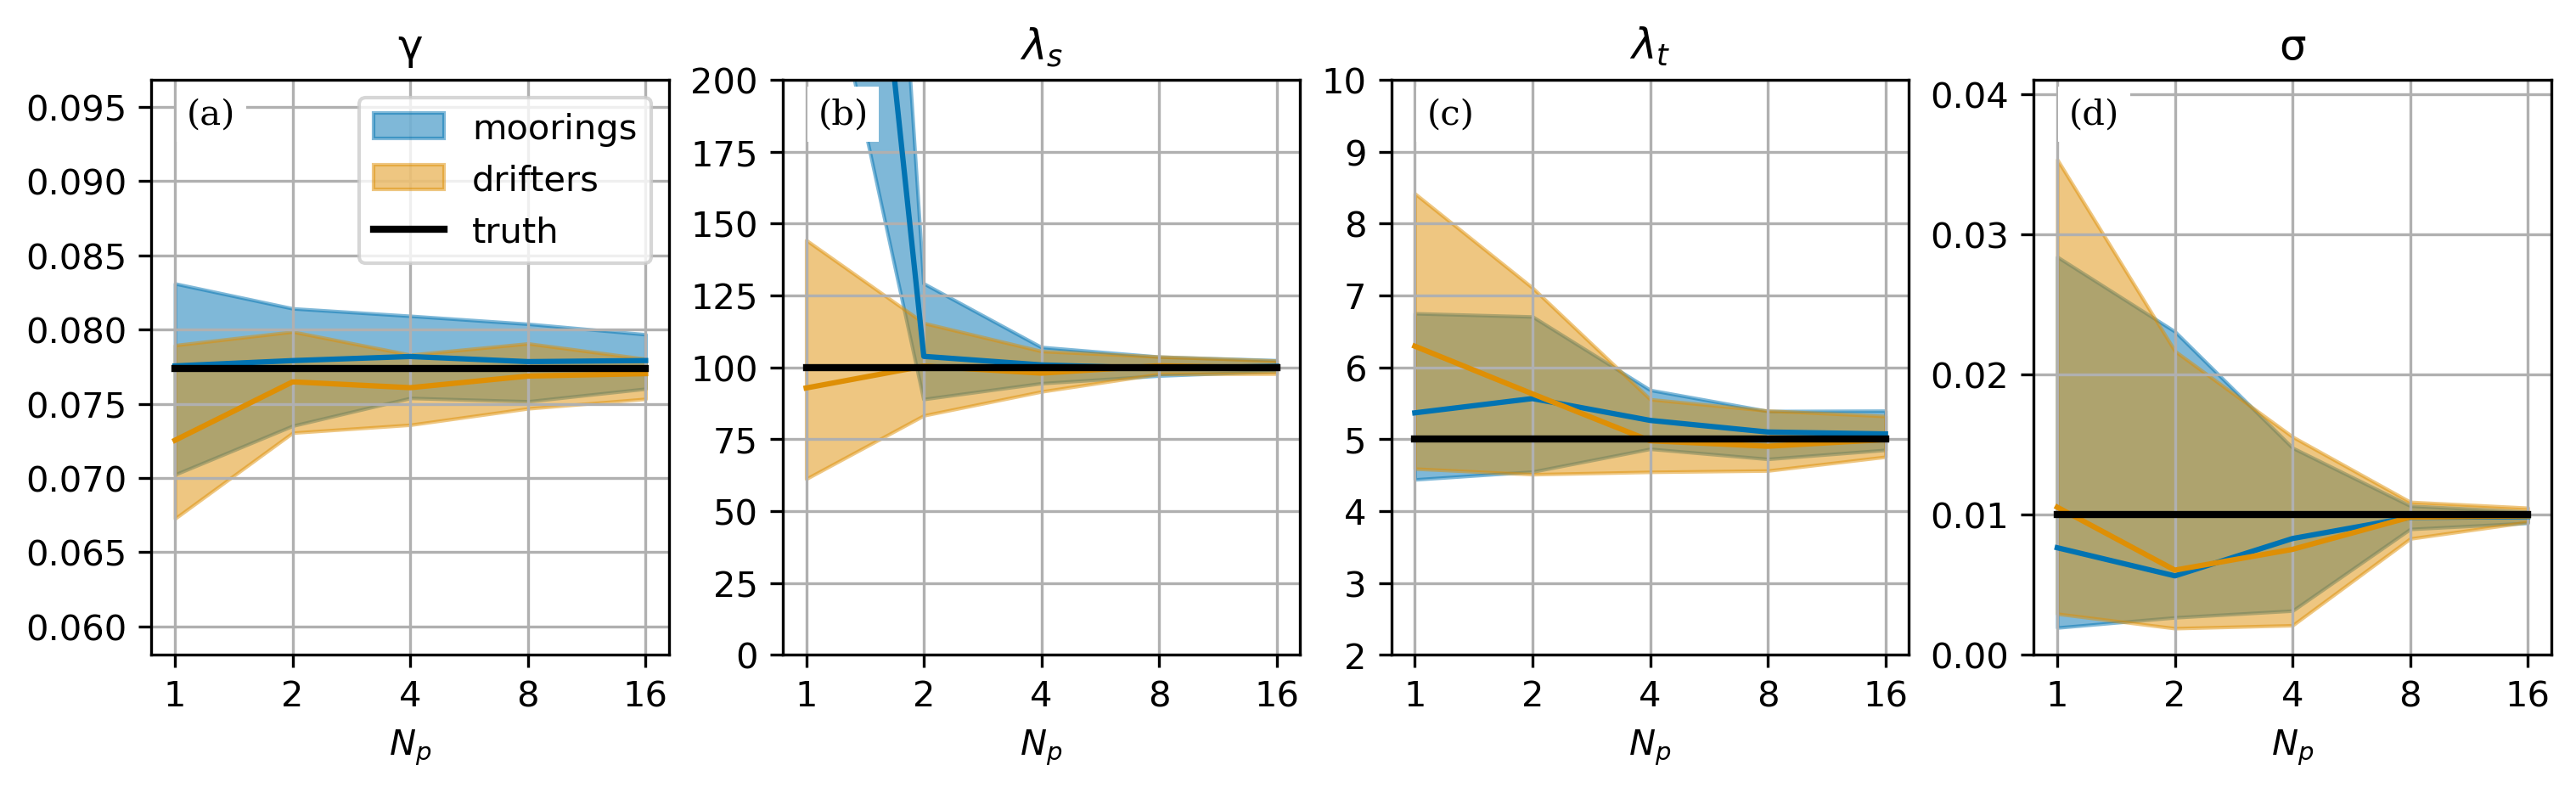

In [12]:
fig, axes = st.plot_sensitivity_combined(dsm, dsr, alpha=0.5, **kw)
#fig, axes = st.plot_sensitivity_combined(dsm, None, alpha=0.5, **kw)
st.label_and_print(fig, axes, flow_attrs["cov_x"]+"_array_optim")

In [15]:
# print MAP - truth difference along with normalized difference
print("%%% Mooring normalized IQW")
st.print_quantile_width(dsm, "Nxy")
print("%%% Mooring ratio to truth and normalized difference to truth")
st.print_MAP_truth_difference(dsm, "Nxy")

%%% Mooring normalized IQW
% Nxy | γ | λx | λt | σ
% 1 | 0.17 | 4.78 | 0.46 | 2.64
% 2 | 0.10 | 0.40 | 0.43 | 2.04
% 4 | 0.07 | 0.13 | 0.16 | 1.16
% 8 | 0.07 | 0.07 | 0.13 | 0.17
% 16 | 0.05 | 0.04 | 0.11 | 0.08
%%% Mooring ratio to truth and normalized difference to truth
% Nxy | γ | λx | λt | σ
% 1 | 0.08 / 0.08 | 490.49 / 100.00 | 5.37 / 5.00 | 0.01 / 0.01
% normalized diff | 0.1 | 79.6 | 6.8 | -31.0
% 2 | 0.08 / 0.08 | 103.80 / 100.00 | 5.56 / 5.00 | 0.01 / 0.01
% normalized diff | 0.6 | 3.7 | 10.1 | -77.7
% 4 | 0.08 / 0.08 | 100.82 / 100.00 | 5.26 / 5.00 | 0.01 / 0.01
% normalized diff | 0.9 | 0.8 | 5.0 | -20.7
% 8 | 0.08 / 0.08 | 99.66 / 100.00 | 5.10 / 5.00 | 0.01 / 0.01
% normalized diff | 0.5 | -0.3 | 2.0 | -2.0
% 16 | 0.08 / 0.08 | 100.34 / 100.00 | 5.07 / 5.00 | 0.01 / 0.01
% normalized diff | 0.6 | 0.3 | 1.4 | -1.5


In [16]:
# print MAP - truth difference along with normalized difference
print("%%% Drifter normalized IQW")
st.print_quantile_width(dsr, "Nxy")
print("%%% Drifter ratio to truth and normalized difference to truth")
st.print_MAP_truth_difference(dsr, "Nxy")

%%% Drifter normalized IQW
% Nxy | γ | λx | λt | σ
% 1 | 0.15 | 0.83 | 0.77 | 3.24
% 2 | 0.09 | 0.32 | 0.52 | 1.98
% 4 | 0.06 | 0.14 | 0.20 | 1.34
% 8 | 0.06 | 0.06 | 0.17 | 0.26
% 16 | 0.03 | 0.05 | 0.11 | 0.10
%%% Drifter ratio to truth and normalized difference to truth
% Nxy | γ | λx | λt | σ
% 1 | 0.07 / 0.08 | 92.80 / 100.00 | 6.29 / 5.00 | 0.01 / 0.01
% normalized diff | -6.8 | -7.8 | 20.6 | 5.0
% 2 | 0.08 / 0.08 | 100.41 / 100.00 | 5.63 / 5.00 | 0.01 / 0.01
% normalized diff | -1.3 | 0.4 | 11.2 | -65.7
% 4 | 0.08 / 0.08 | 97.96 / 100.00 | 4.98 / 5.00 | 0.01 / 0.01
% normalized diff | -1.8 | -2.1 | -0.4 | -33.0
% 8 | 0.08 / 0.08 | 100.54 / 100.00 | 4.90 / 5.00 | 0.01 / 0.01
% normalized diff | -0.8 | 0.5 | -2.0 | -1.9
% 16 | 0.08 / 0.08 | 99.74 / 100.00 | 4.99 / 5.00 | 0.01 / 0.01
% normalized diff | -0.6 | -0.3 | -0.1 | -1.0


In [19]:
#fig, axes = st.plot_sensitivity_combined(dsm, dsr, type="boxplot", **kw)
#st.label_and_print(fig, axes, flow_attrs["cov_x"]+"_indep_platforms_MAP0")

/home1/datawork/aponte/code/nwastats/nwastats/__init__.py:1971: RuntimeWarning: divide by zero encountered in log2
  return np.log2(x)


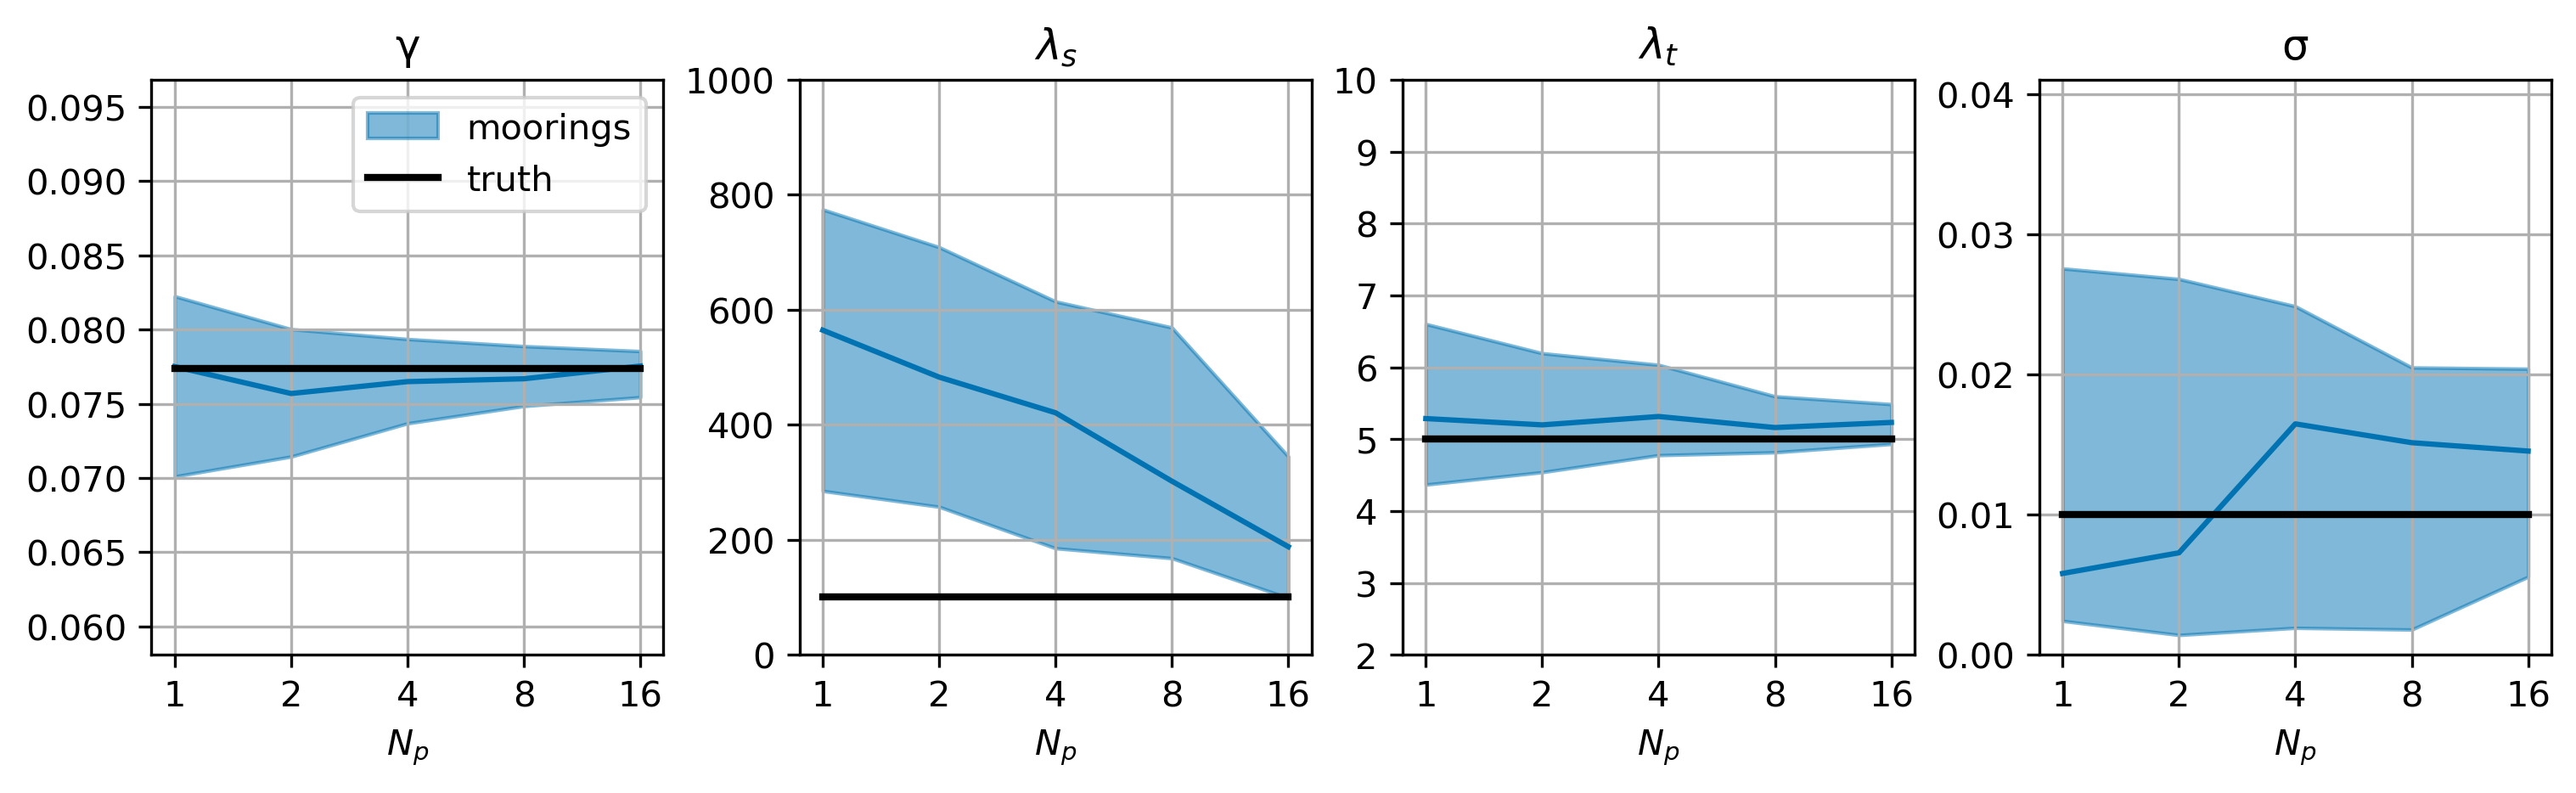

In [20]:
fig, axes = st.plot_sensitivity_combined(
    dsm, None, label="moorings", alpha=0.5, **kw,
)

/home1/datawork/aponte/code/nwastats/nwastats/__init__.py:1971: RuntimeWarning: divide by zero encountered in log2
  return np.log2(x)


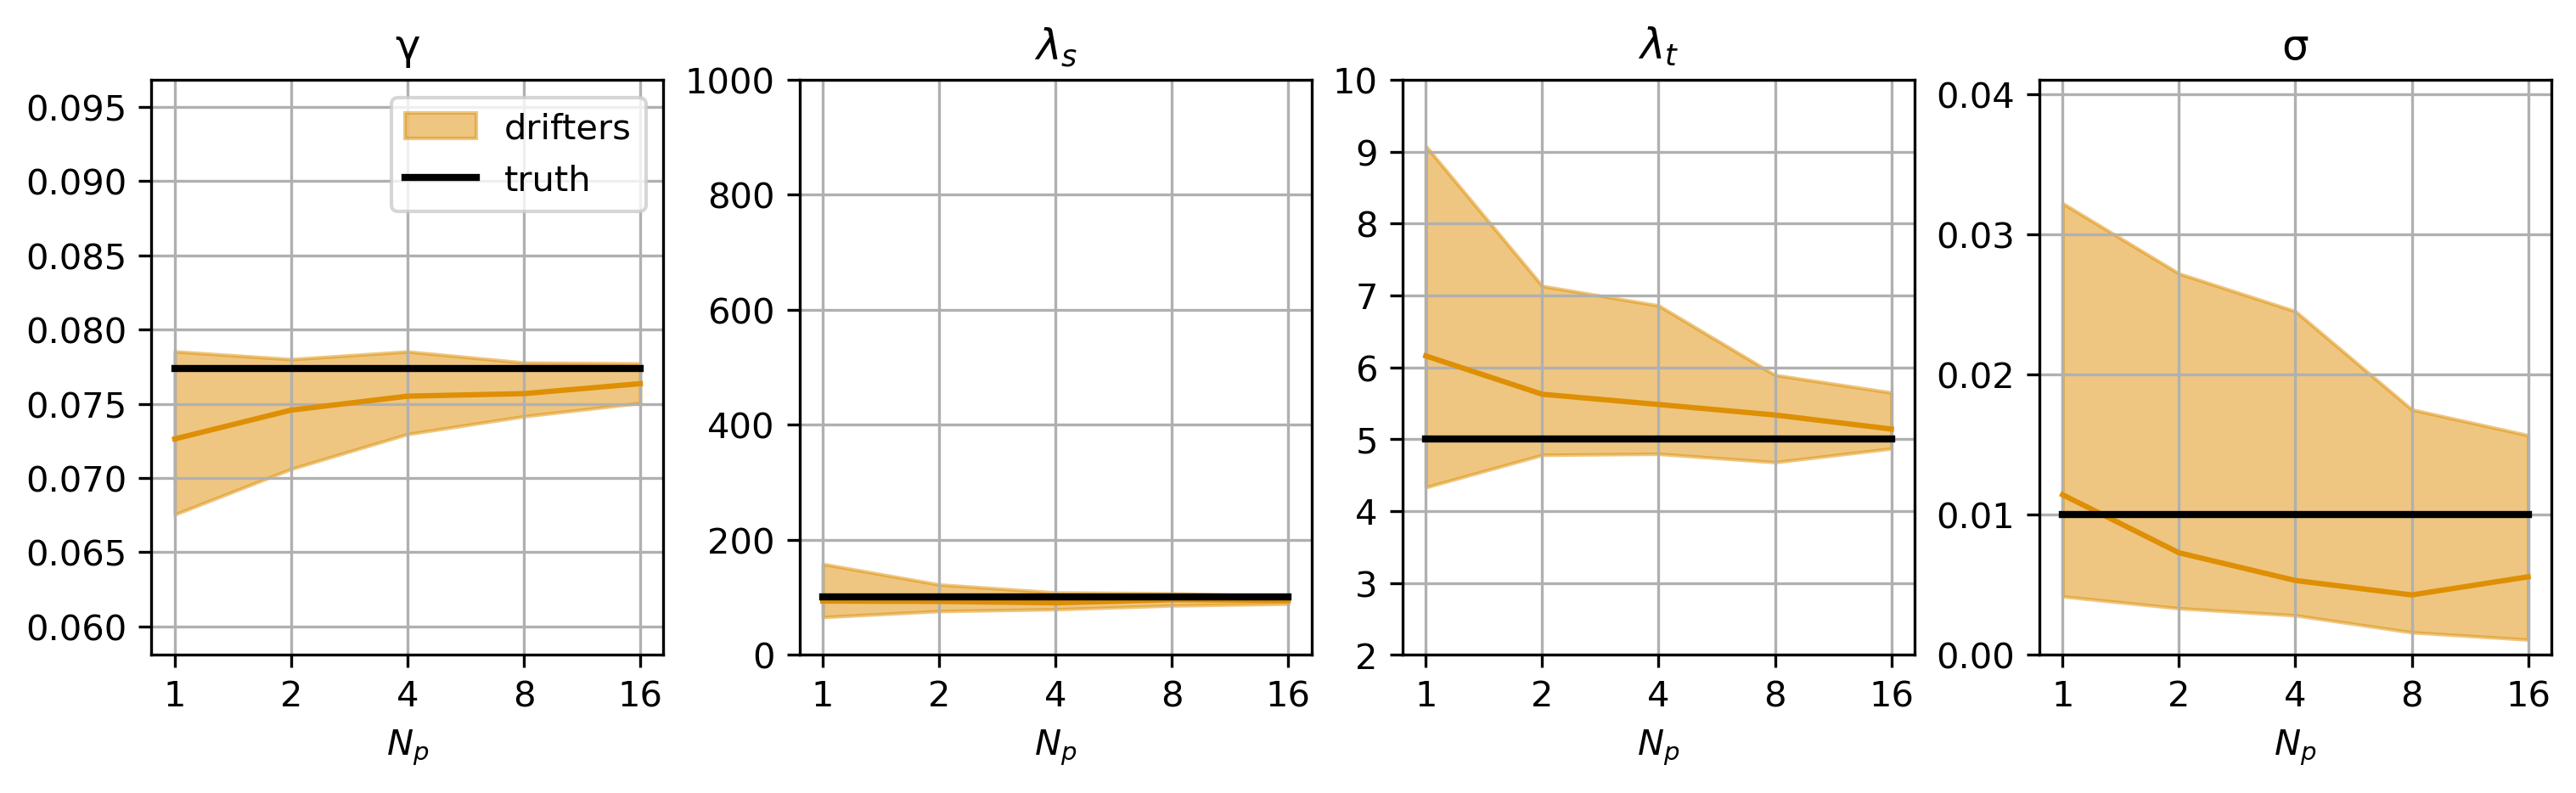

In [21]:
fig, axes = st.plot_sensitivity_combined(
    dsr, None, label="drifters", alpha=0.5, c=colors["dr"], **kw,
)

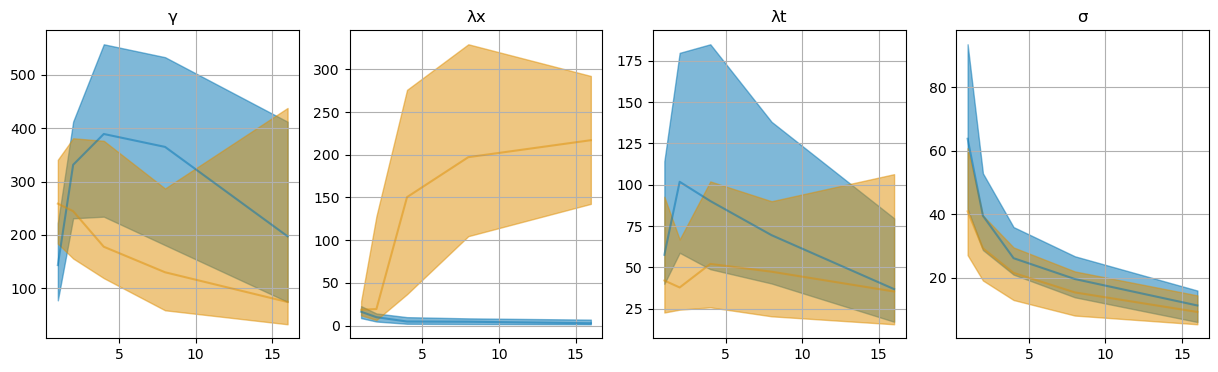

In [23]:
# show ess

def show_variable_parameter(v, dim):

    fig, axes = plt.subplots(1, dsm.parameter.size, figsize=(15,4))
    
    _ds, c = dsm, st.colors["mo"]
    for p, ax in zip(_ds.parameter, axes):
        da = _ds[v].sel(parameter=p).quantile([1/4,1/2,3/4], "ensemble")
        kwargs = dict(color=c, alpha=.5)
        ax.plot(da[dim], da.sel(quantile=1/2), **kwargs)
        h = ax.fill_between(da[dim], da.sel(quantile=1/4), da.sel(quantile=3/4), **kwargs)
        ax.grid()
        ax.set_title(p.data)
    
    _ds, c = dsr, st.colors["dr"]
    for p, ax in zip(_ds.parameter, axes):
        da = _ds[v].sel(parameter=p).quantile([1/4,1/2,3/4], "ensemble")
        kwargs = dict(color=c, alpha=.5)
        ax.plot(da[dim], da.sel(quantile=1/2), **kwargs)
        h = ax.fill_between(da[dim], da.sel(quantile=1/4), da.sel(quantile=3/4), **kwargs)

show_variable_parameter("ess", "Nxy")

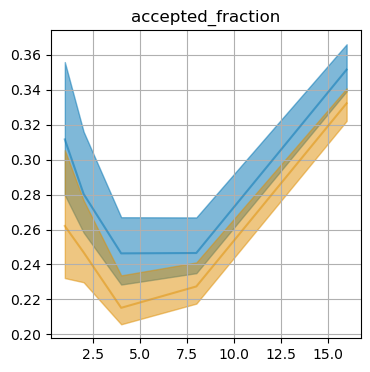

In [24]:

def show_variable_global(v, dim):

    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    
    _ds, c = dsm, st.colors["mo"]
    da = _ds[v].quantile([1/4,1/2,3/4], "ensemble")
    kwargs = dict(color=c, alpha=.5)
    ax.plot(da[dim], da.sel(quantile=1/2), **kwargs)
    h = ax.fill_between(da[dim], da.sel(quantile=1/4), da.sel(quantile=3/4), **kwargs)
    ax.grid()
    ax.set_title(v)
    
    _ds, c = dsr, st.colors["dr"]
    da = _ds[v].quantile([1/4,1/2,3/4], "ensemble")
    kwargs = dict(color=c, alpha=.5)
    ax.plot(da[dim], da.sel(quantile=1/2), **kwargs)
    h = ax.fill_between(da[dim], da.sel(quantile=1/4), da.sel(quantile=3/4), **kwargs)

show_variable_global("accepted_fraction", "Nxy")

---

## mooring inference plot

In [ ]:
ds = Dm[0]

_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)

#### Empirical convergence metrics 

In [7]:
def show_convergence(ds):
    """ split time series in half and compare mean and std"""

    N = ds["i"].size
    ds0 = ds.isel(i=slice(0,N//2))
    ds0m = ds0.mean(["i"])
    ds0std = ds0.std(["i"])
    ds1 = ds.isel(i=slice(N//2,None))
    ds1m = ds1.mean(["i"])
    ds1std = ds1.std(["i"])

    # mean
    fig, axes = plt.subplots(ds.parameter.size,1,figsize=(5,5), sharex=True,)
    for p, ax in zip(ds.parameter.values, axes):
        _da = ds0m.sel(parameter=p).samples
        _da.plot(ax=ax)
        _da = ds1m.sel(parameter=p).samples
        _da.plot(ax=ax)
        ax.set_title(p+" mean")
        if p!=ds.parameter.values[-1]:
            ax.set_xlabel("")
    plt.subplots_adjust(hspace=0.5)

    # mean
    fig, axes = plt.subplots(ds.parameter.size,1,figsize=(5,5), sharex=True,)
    for p, ax in zip(ds.parameter.values, axes):
        _da = ds0std.sel(parameter=p).samples
        _da.plot(ax=ax)
        _da = ds1std.sel(parameter=p).samples
        _da.plot(ax=ax)
        ax.set_title(p+" std")
        if p!=ds.parameter.values[-1]:
            ax.set_xlabel("")
    plt.subplots_adjust(hspace=0.5)

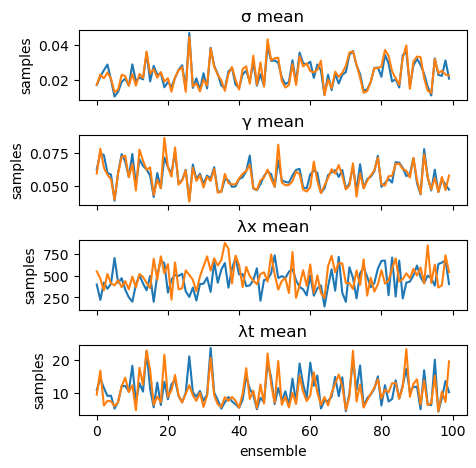

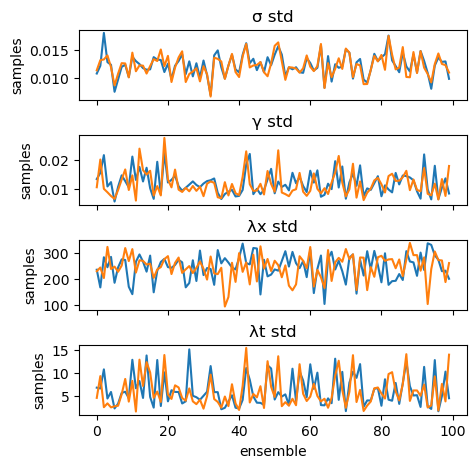

In [8]:
show_convergence(ds)

#### Effective sample size

In [9]:
samples = ds.samples.isel(ensemble=0).values
samples_az = st.convert_to_az(samples, labels)
Ndof = az.ess(samples_az)
print(Ndof)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    σ        float64 253.2
    γ        float64 117.0
    λx       float64 9.687
    λt       float64 85.95


#### MAP

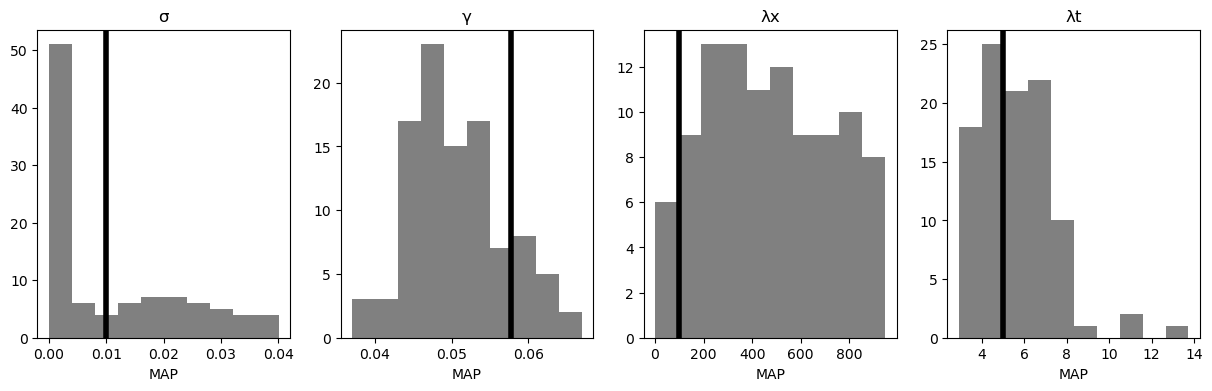

In [10]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _ds.MAP.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)) #+ " - MAP"
    ax.axvline(_tr, color="k", lw=4)

#### mean/std

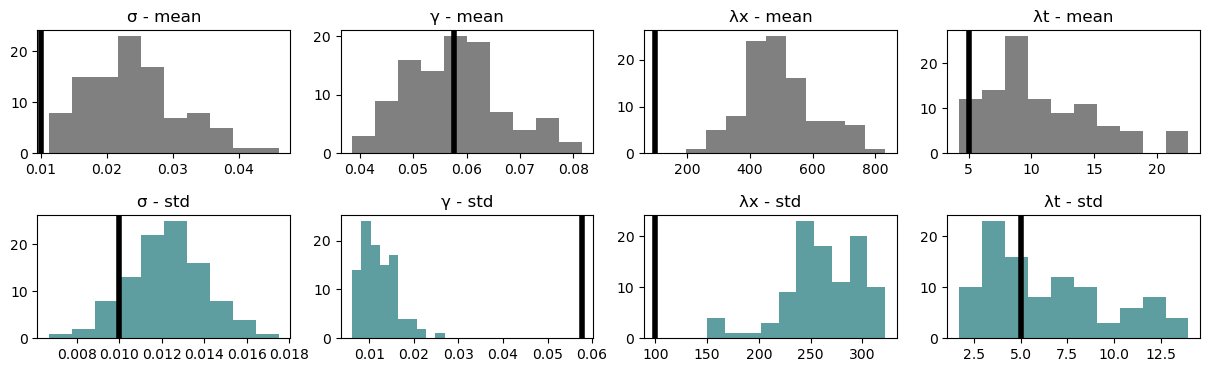

In [11]:
fig, axes = plt.subplots(2, ds.parameter.size, figsize=(15,4), gridspec_kw=dict(hspace=.5))

# mean
for p, ax in zip(ds.parameter, axes[0,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.mean("i")
    _da.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)+" - mean")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")
    
# std
for p, ax in zip(ds.parameter, axes[1,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.std("i")
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.set_title(str(p.values)+ " - std")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")

#### quantiles

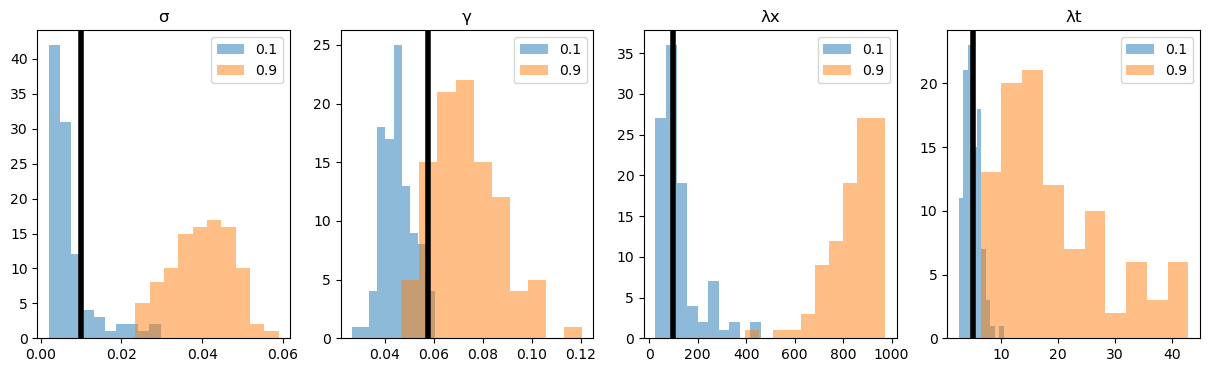

In [12]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    for q in qt:
        _da.sel(quantile=q).plot.hist(ax=ax, bins=10, alpha=.5, label=f"{q}")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")
    ax.legend()

##### quantiles 0.1 0.9 difference

this larger than std by a factor of about 2

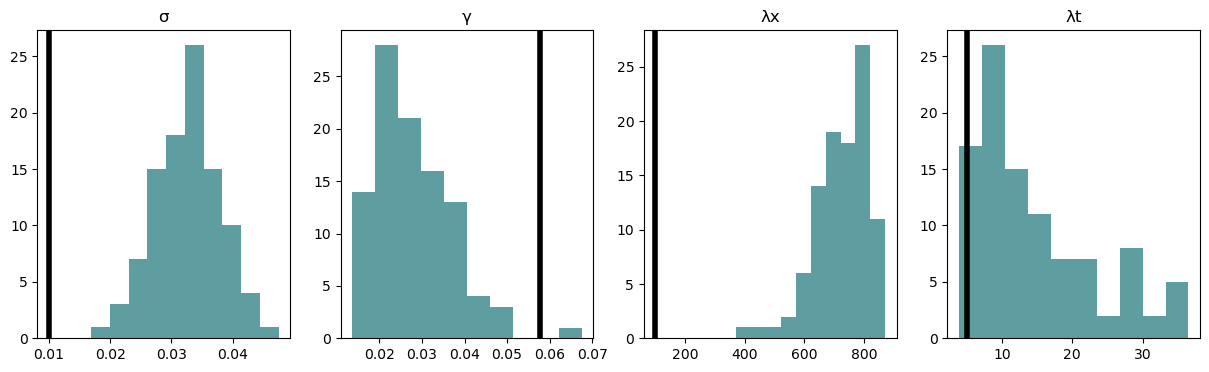

In [13]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _da = _da.sel(quantile=qt[1]) - _da.sel(quantile=qt[0])
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")

---
## drifter inference plot

- Lagrangian simulation
- actual inference


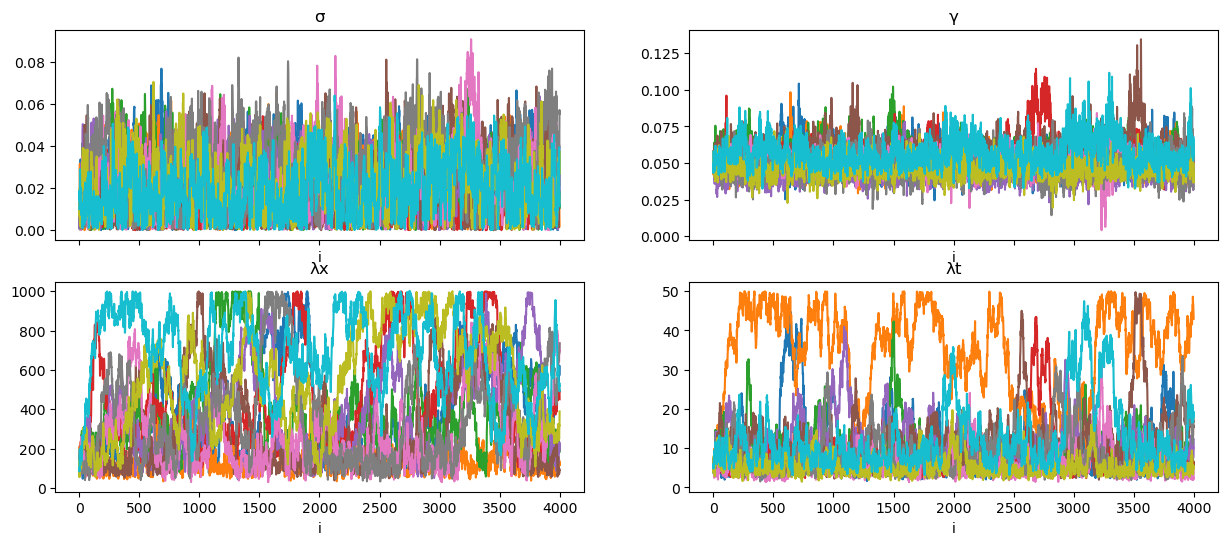

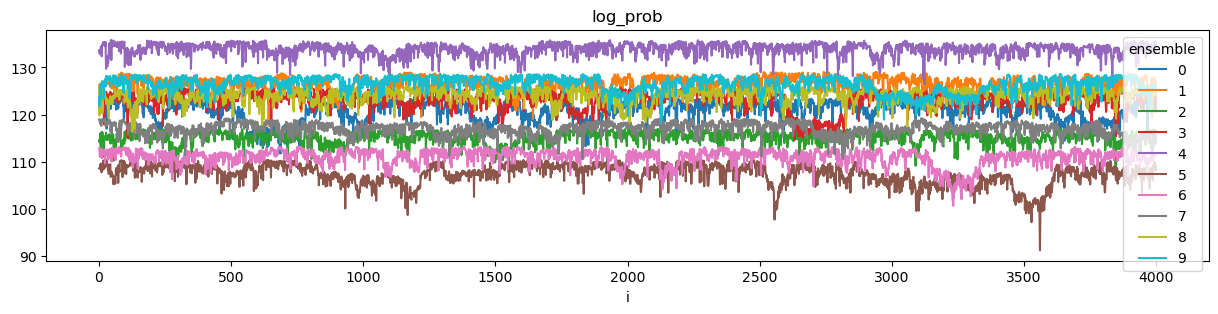

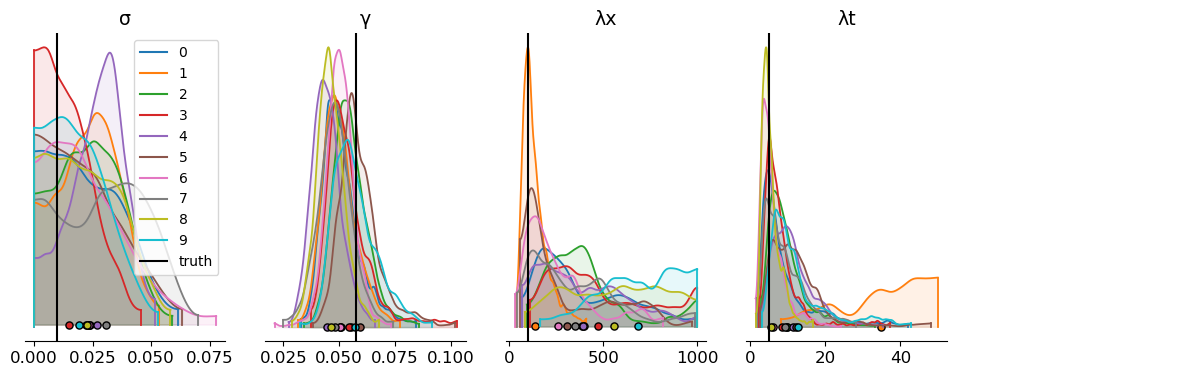

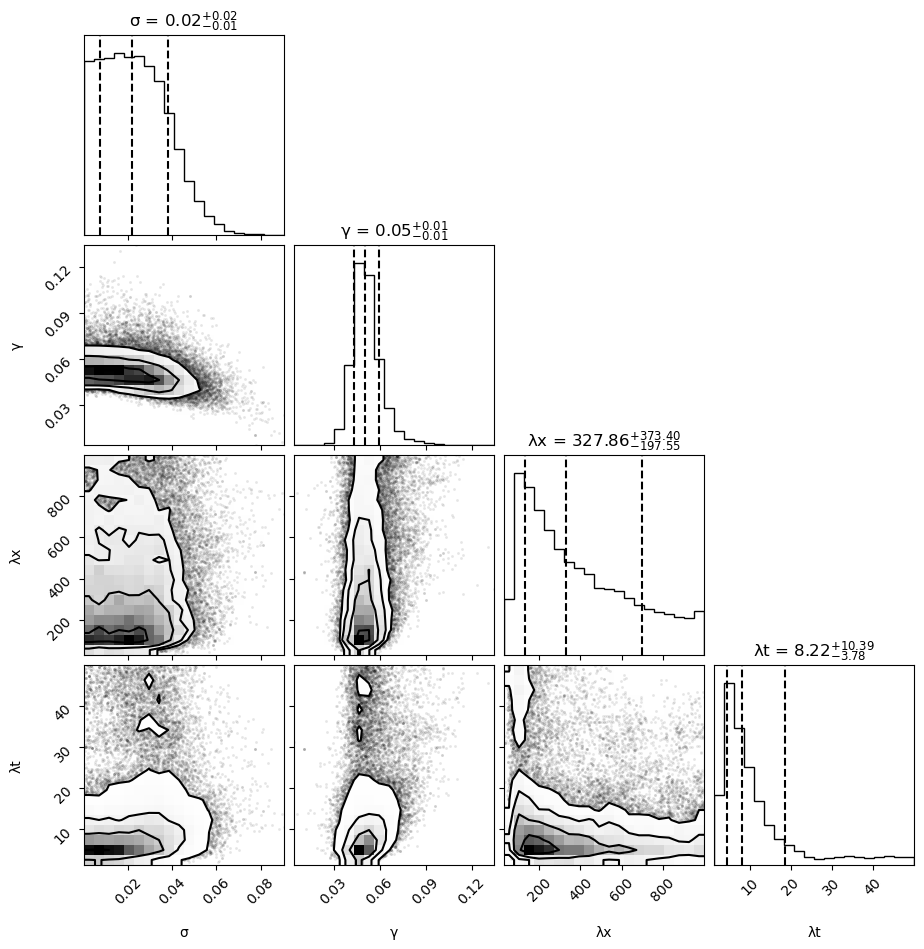

In [15]:
ds = Dm[0]

_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)

#### MAP

The underestimation of $\gamma$ may be related to interference with the noise parameter inference (see joint distributions above) and the fact we allow for substantial values of the noise compared to the $\gamma$ ... to be verified

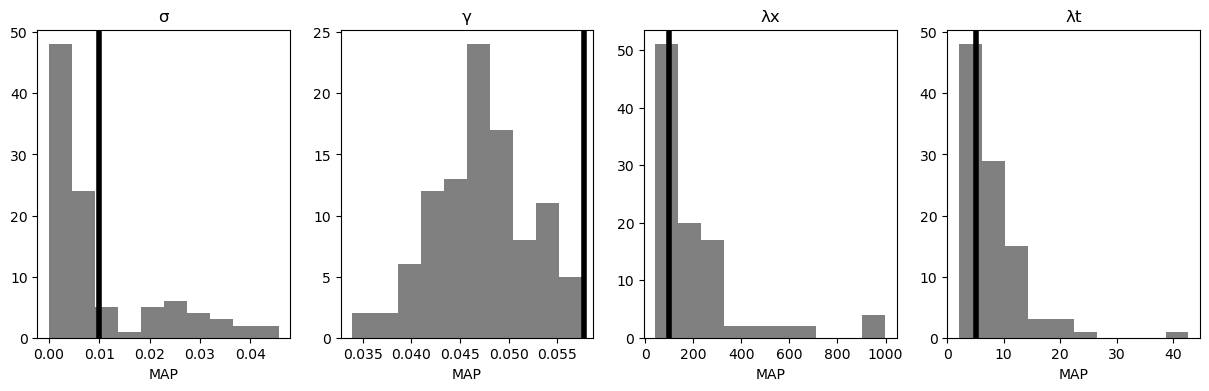

In [16]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _ds.MAP.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)) #+ " - MAP"
    ax.axvline(_tr, color="k", lw=4)

#### mean/std

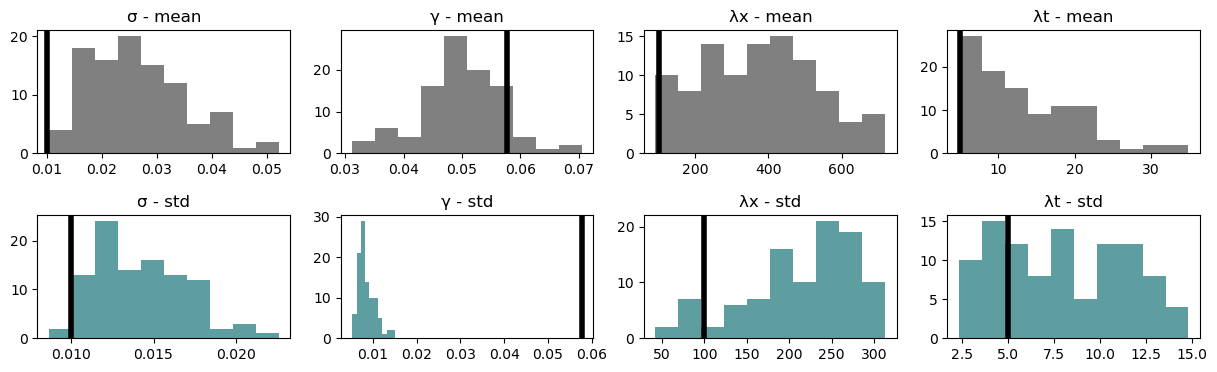

In [17]:
fig, axes = plt.subplots(2, ds.parameter.size, figsize=(15,4), gridspec_kw=dict(hspace=.5))

# mean
for p, ax in zip(ds.parameter, axes[0,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.mean("i")
    _da.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)+" - mean")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")
    
# std
for p, ax in zip(ds.parameter, axes[1,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.std("i")
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.set_title(str(p.values)+ " - std")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")

#### quantiles

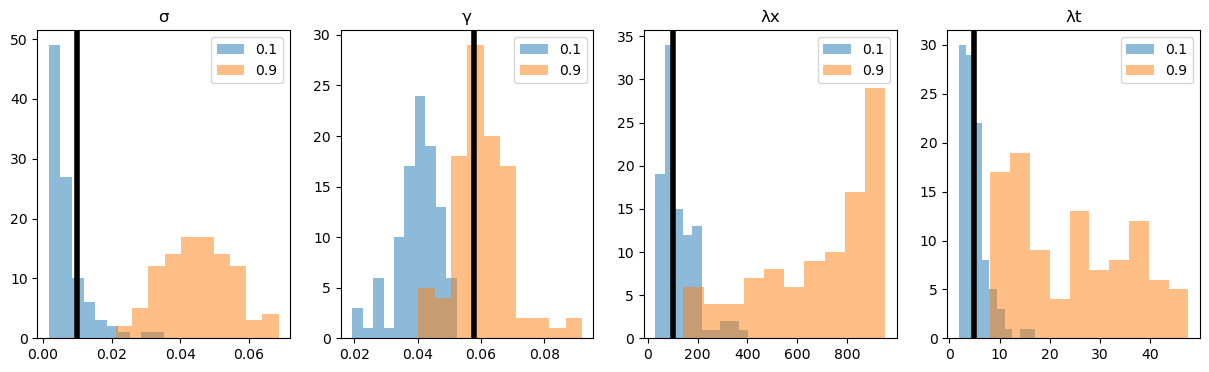

In [18]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    for q in qt:
        _da.sel(quantile=q).plot.hist(ax=ax, bins=10, alpha=.5, label=f"{q}")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")
    ax.legend()

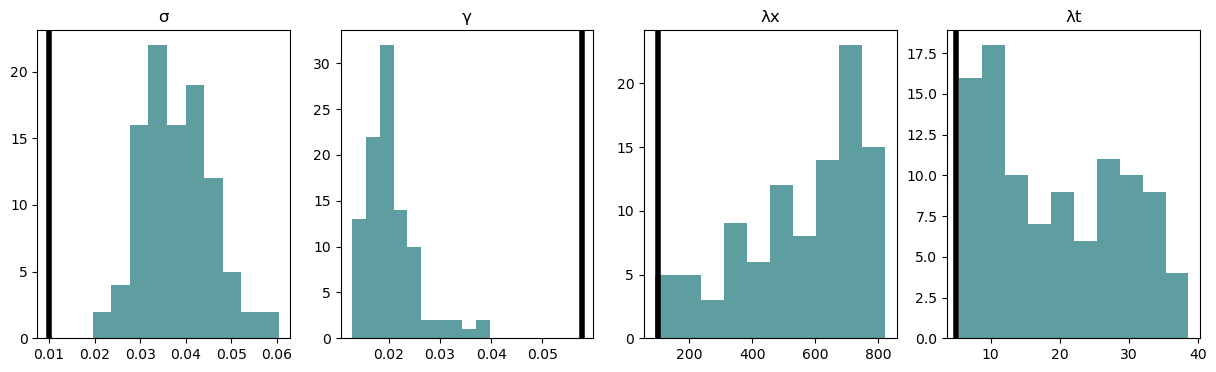

In [19]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _da = _da.sel(quantile=qt[1]) - _da.sel(quantile=qt[0])
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")